In [19]:
# In order to import event extraction module...
import sys
sys.path.append('/Users/gvieira/code/toneto/shan')

In [20]:
import math
import json
from random import random
import numpy as np

import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths, lfilter, lfilter_zi, filtfilt, butter

from eventextraction import smooth_without_delay, extract_peaks

In [21]:
def plot(seq):
    plt.scatter([i for i in range(len(seq))], seq)

In [22]:
def make_noisy(seq, amp=0.2): # seq is a numpy array
    noise_amp = amp * abs(seq.max() - seq.min())
    return np.array([(y + (random()*noise_amp/2) - (random()*noise_amp/2)) for y in seq])

### How to extract a peak from an observed approximate maximum intersection area?

In order to calibrate the parameters for the Buttersworth filter, we eyeball the video after object tracking and estimate that a good minimal area threshold to trigger an interaction is about `~3000` pixels. (We do this by exporting the tracks and printing them using one of the provided scripts. Then we look at the intersection when a person interacts with a ROI; by stopping the video around the "climax" of the interaction, we read the intersection area that is currently being displayed and thus choose our `min_height` parameter.)

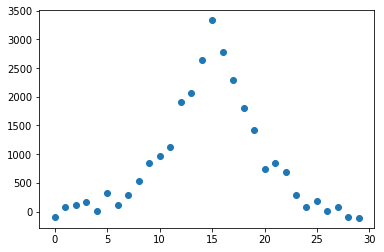

In [28]:
# In other words, if this were the graph of the intersection area over time and *we did not plot this*, we'd still
# be able to tell that the peak is somewhat above 3000.
iaot = make_noisy(np.array([math.pow(i, 3) for i in range(15)] + [math.pow(15 - i, 3) for i in range(15)]))
plot(iaot)

The problem is when we apply our current filtering technique (that uses a Buttersworth filter, [copied verbatim from this article from the SciPy cookbook](https://scipy-cookbook.readthedocs.io/items/FiltFilt.html)), we manage to smooth out the signal without delaying it (ie, sliding it on the `x` axis) but *we end up changing the amplitude of the signal* (ie, we mess with the `y` axis):

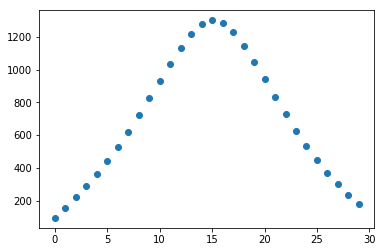

In [29]:
params = {
    'butter_ord': 1,
    'butter_crit_freq': 0.05
}
smooth_iaot = smooth_without_delay(iaot, **params)
plot(smooth_iaot)

The problem is when we try to extract the peaks using our eye-balled value of `3000` it would obviously not work (in the graph above, the peak is a little above `1200`):

In [30]:
extract_peaks(smooth_iaot, min_height=3000, min_width=1)

[]

So we need to make sure to interpolate it back to the original range using Numpy's `interp` function:

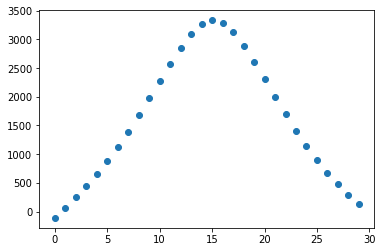

In [31]:
interp_iaot = np.interp(smooth_iaot, (smooth_iaot.min(), smooth_iaot.max()), (iaot.min(), iaot.max()))
plot(interp_iaot)

And now we can extract the peak using our eye-balled value of `3000`:

In [32]:
extract_peaks(interp_iaot, min_height=3000, min_width=1)

[Peak(index=15, duration=13.698724116492391, height=3330.883640676121)]

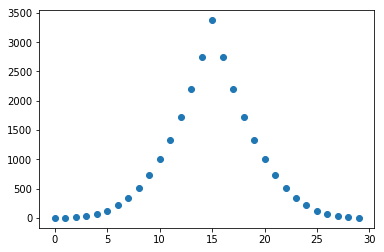

In [33]:
plot([math.pow(i, 3) for i in range(15)] + [] + [math.pow(15 - i, 3) for i in range(15)])